<a href="https://colab.research.google.com/github/DavAF/Apredizaje_matem-tico/blob/main/Regresi%C3%B3n_log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instala PuLP si no lo tienes
!pip install pulp
from pulp import listSolvers
print(listSolvers(onlyAvailable=True))
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpInteger

# 1. Crear datos aleatorios simulados
np.random.seed(42)
n_oficinas = 20
data = {
    'cod_centro': [f'C{i:03d}' for i in range(n_oficinas)],
    'tipo_oficina': np.random.choice(['pequena', 'mediana', 'grande'], size=n_oficinas),
    'volumen_negocio': np.random.randint(1000, 10000, size=n_oficinas),
    'clientes': np.random.randint(100, 1000, size=n_oficinas),
    'recursos': np.random.randint(10, 100, size=n_oficinas),
    'margen': np.random.uniform(0.05, 0.3, size=n_oficinas),
    'ratio': np.random.uniform(0.5, 2.0, size=n_oficinas),
    'poblacion': np.random.randint(5000, 100000, size=n_oficinas),
}
df = pd.DataFrame(data)

# 2. Definir FTE mínimos y máximos
min_fte_tipo = {'pequena': 2, 'mediana': 3, 'grande': 5}
df['min_fte'] = df['tipo_oficina'].map(min_fte_tipo)
df['max_fte'] = df['poblacion'] // 10000 + 3

# 3. Calcular score ponderado
cols = ['volumen_negocio', 'clientes', 'recursos', 'margen', 'ratio']
for col in cols:
    df[col + '_norm'] = df[col] / df[col].max()

pesos = [0.2] * 5  # puedes personalizar esto
df['score'] = sum(p * df[col + '_norm'] for p, col in zip(pesos, cols))

# 4. Calcular FTE teórico proporcional
total_fte = 100
df['fte_teorico'] = total_fte * df['score'] / df['score'].sum()

# 5. Modelo de optimización con desviación absoluta
model = LpProblem("AsignacionFTE", LpMinimize)
fte_vars = {}
z_vars = {}

for _, row in df.iterrows():
    c = row['cod_centro']
    fte_vars[c] = LpVariable(f"fte_{c}", lowBound=row['min_fte'], upBound=row['max_fte'], cat=LpInteger)
    z_vars[c] = LpVariable(f"z_{c}", lowBound=0)

    # Restricciones de desviación absoluta
    model += fte_vars[c] - row['fte_teorico'] <= z_vars[c]
    model += row['fte_teorico'] - fte_vars[c] <= z_vars[c]

# 6. Objetivo: minimizar desviaciones
model += lpSum(z_vars.values())

# 7. Restricción de FTE total
model += lpSum(fte_vars.values()) <= total_fte

# 8. Resolver modelo
model.solve()

# 9. Guardar resultados
df['fte_optimo'] = df['cod_centro'].apply(lambda x: fte_vars[x].varValue)

# 10. Mostrar resultados
df_resultado = df[['cod_centro', 'tipo_oficina', 'fte_teorico', 'fte_optimo', 'min_fte', 'max_fte']]
display(df_resultado)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.2 MB/s eta 0:00:00
['PULP_CBC_CMD', 'HiGHS']


PulpSolverError: Pulp: Error while executing /usr/local/lib/python3.11/dist-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc

[0. 0.]


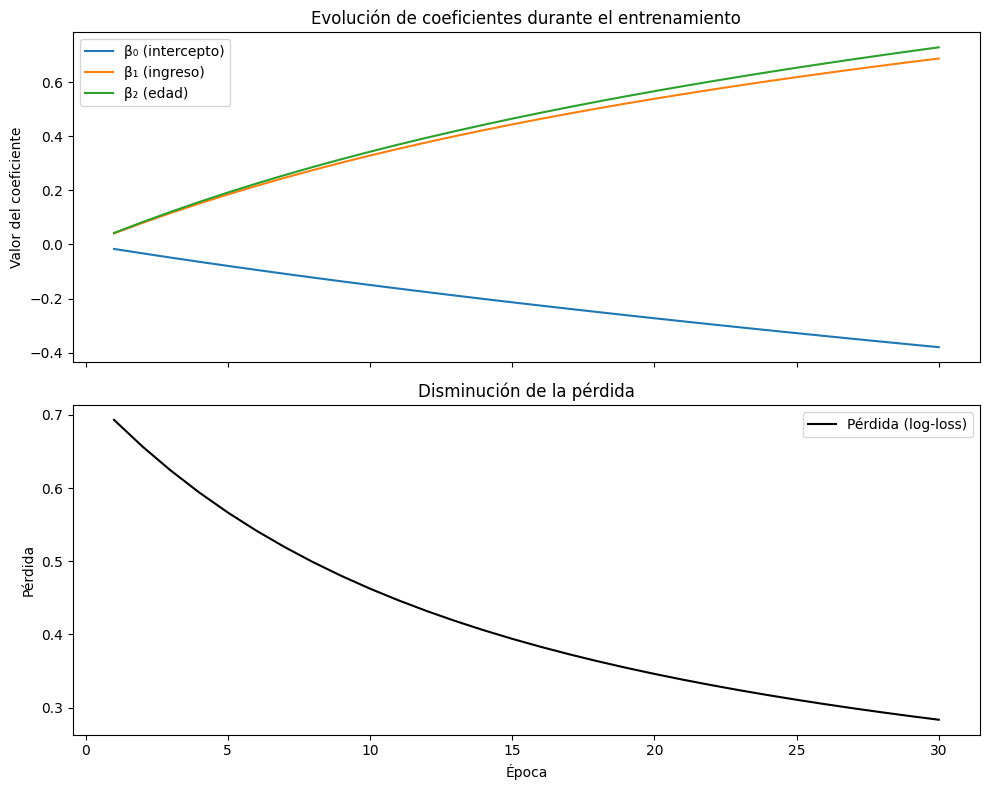


🔎 Coeficientes finales después del entrenamiento:
β₀ (intercepto): -0.37980
β₁ (ingreso):    0.68716
β₂ (edad):       0.72845

📊 Predicción para nueva persona:
Ingreso: 5200, Edad: 35
z = 0.44163
Probabilidad de que compre (p): 0.6086
➡️ El modelo predice que SÍ comprará.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Datos simulados (ingreso, edad) y etiquetas (compra: 0 o 1)
X = np.array([
    [3000, 22],
    [4500, 30],
    [6000, 40]
], dtype=float)
y = np.array([0, 0, 1])

# Paso 2: Normalizar (media 0, varianza 1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Paso 3: Inicializar parámetros
beta_0 = 0.0
beta = np.zeros(X.shape[1])  # [beta_1, beta_2]
learning_rate = 0.1
epochs = 30

# Para guardar historia de entrenamiento
history = {
    "epoch": [],
    "beta_0": [],
    "beta_1": [],
    "beta_2": [],
    "loss": []
}

# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Predicción
def predict(X, beta_0, beta):
    z = beta_0 + np.dot(X, beta)
    return sigmoid(z)

# Pérdida logarítmica (log-loss)
def compute_loss(p, y):
    epsilon = 1e-10  # evitar log(0)
    return -np.mean(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))

# Entrenamiento
for epoch in range(1, epochs + 1):
    p = predict(X_norm, beta_0, beta)
    error = p - y

    # Gradientes
    db0 = np.mean(error)
    db = np.dot(error, X_norm) / len(X)

    # Actualización
    beta_0 -= learning_rate * db0
    beta -= learning_rate * db

    # Pérdida
    loss = compute_loss(p, y)

    # Guardar resultados
    history["epoch"].append(epoch)
    history["beta_0"].append(beta_0)
    history["beta_1"].append(beta[0])
    history["beta_2"].append(beta[1])
    history["loss"].append(loss)

# Graficar evolución
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Coeficientes
ax[0].plot(history["epoch"], history["beta_0"], label="β₀ (intercepto)")
ax[0].plot(history["epoch"], history["beta_1"], label="β₁ (ingreso)")
ax[0].plot(history["epoch"], history["beta_2"], label="β₂ (edad)")
ax[0].set_ylabel("Valor del coeficiente")
ax[0].set_title("Evolución de coeficientes durante el entrenamiento")
ax[0].legend()

# Pérdida
ax[1].plot(history["epoch"], history["loss"], color="black", label="Pérdida (log-loss)")
ax[1].set_xlabel("Época")
ax[1].set_ylabel("Pérdida")
ax[1].set_title("Disminución de la pérdida")
ax[1].legend()

plt.tight_layout()
plt.show()

# Mostrar coeficientes finales después del entrenamiento
print("\n🔎 Coeficientes finales después del entrenamiento:")
print(f"β₀ (intercepto): {beta_0:.5f}")
print(f"β₁ (ingreso):    {beta[0]:.5f}")
print(f"β₂ (edad):       {beta[1]:.5f}")

# ➕ NUEVA PREDICCIÓN

# Paso 1: Ingreso y edad de una nueva persona
nuevo_ingreso = 5200
nueva_edad = 35

# Paso 2: Normalizar con los mismos valores usados en el entrenamiento
x_nuevo_norm = np.array([
    (nuevo_ingreso - X_mean[0]) / X_std[0],
    (nueva_edad   - X_mean[1]) / X_std[1]
])

# Paso 3: Calcular z y aplicar sigmoide
z = beta_0 + np.dot(x_nuevo_norm, beta)
p = 1 / (1 + np.exp(-z))

# Paso 4: Mostrar resultados
print("\n📊 Predicción para nueva persona:")
print(f"Ingreso: {nuevo_ingreso}, Edad: {nueva_edad}")
print(f"z = {z:.5f}")
print(f"Probabilidad de que compre (p): {p:.4f}")

# Interpretación simple
if p >= 0.5:
    print("➡️ El modelo predice que SÍ comprará.")
else:
    print("➡️ El modelo predice que NO comprará.")




[4.53978687e-05 5.55606489e-05 6.79983174e-05 8.32200197e-05
 1.01848815e-04 1.24647146e-04 1.52547986e-04 1.86692945e-04
 2.28478855e-04 2.79614739e-04 3.42191434e-04 4.18766684e-04
 5.12469082e-04 6.27124987e-04 7.67413430e-04 9.39055039e-04
 1.14904229e-03 1.40591988e-03 1.72012560e-03 2.10440443e-03
 2.57431039e-03 3.14881358e-03 3.85103236e-03 4.70911357e-03
 5.75728612e-03 7.03711536e-03 8.59898661e-03 1.05038445e-02
 1.28252101e-02 1.56514861e-02 1.90885420e-02 2.32625358e-02
 2.83228820e-02 3.44451957e-02 4.18339400e-02 5.07243606e-02
 6.13831074e-02 7.41067363e-02 8.92170603e-02 1.07052146e-01
 1.27951705e-01 1.52235823e-01 1.80176593e-01 2.11963334e-01
 2.47663801e-01 2.87185901e-01 3.30246430e-01 3.76354517e-01
 4.24816868e-01 4.74768924e-01 5.25231076e-01 5.75183132e-01
 6.23645483e-01 6.69753570e-01 7.12814099e-01 7.52336199e-01
 7.88036666e-01 8.19823407e-01 8.47764177e-01 8.72048295e-01
 8.92947854e-01 9.10782940e-01 9.25893264e-01 9.38616893e-01
 9.49275639e-01 9.581660

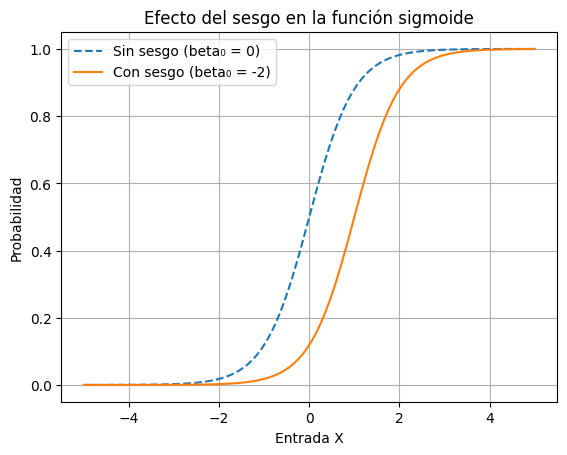

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    print(1 / (1 + np.exp(-z)))
    return 1 / (1 + np.exp(-z))

# Rango de valores de entrada
X = np.linspace(-5, 5, 100)
# Peso fijo
beta = 2.0

# Dos casos: sin sesgo y con sesgo
z_sin_sesgo = beta * X              # beta_0 = 0
z_con_sesgo = -2 + beta * X         # beta_0 = -2

# Aplicamos la sigmoide
p_sin_sesgo = sigmoid(z_sin_sesgo)
p_con_sesgo = sigmoid(z_con_sesgo)

# Graficamos
plt.plot(X, p_sin_sesgo, label='Sin sesgo (beta₀ = 0)', linestyle='--')
plt.plot(X, p_con_sesgo, label='Con sesgo (beta₀ = -2)', linestyle='-')
plt.xlabel('Entrada X')
plt.ylabel('Probabilidad')
plt.title('Efecto del sesgo en la función sigmoide')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpInteger, PULP_CBC_CMD

df = pd.DataFrame({
    'cod_centro': ['C001', 'C002', 'C003'],
    'tipo_oficina': ['pequena', 'mediana', 'grande'],
    'volumen': [5000, 9000, 7000],
    'clientes': [300, 800, 500],
    'recursos': [30, 80, 50],
    'margen': [0.10, 0.25, 0.20],
    'ratio': [1.0, 1.8, 1.2]
})

min_fte_tipo = {'pequena': 2, 'mediana': 3, 'grande': 5}
max_fte_tipo = {'pequena': 4, 'mediana': 5, 'grande': 6}
df['min_fte'] = df['tipo_oficina'].map(min_fte_tipo)
df['max_fte'] = df['tipo_oficina'].map(max_fte_tipo)

indicadores = ['volumen', 'clientes', 'recursos', 'margen', 'ratio']
pesos = [0.3, 0.25, 0.2, 0.15, 0.1]
for col in indicadores:
    df[col + '_z'] = (df[col] - df[col].mean()) / df[col].std()
df['score'] = sum(df[col + '_z'] * w for col, w in zip(indicadores, pesos))
df['adj_score'] = df['score'] - df['score'].min() + 0.001
df['fte_teorico'] = df['adj_score'] / df['adj_score'].sum() * df['max_fte'].sum()

model = LpProblem("Asignacion_FTE_Descentralizada", LpMinimize)
fte_vars, z_vars = {}, {}
for _, row in df.iterrows():
    c = row['cod_centro']
    fte_vars[c] = LpVariable(f"fte_{c}", row['min_fte'], row['max_fte'], LpInteger)
    z_vars[c] = LpVariable(f"z_{c}", lowBound=0)
    model += fte_vars[c] - row['fte_teorico'] <= z_vars[c]
    model += row['fte_teorico'] - fte_vars[c] <= z_vars[c]
model += lpSum(z_vars.values())
model.solve(PULP_CBC_CMD(msg=True))
df['fte_optimo'] = df['cod_centro'].apply(lambda x: fte_vars[x].varValue)


In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpInteger, PULP_CBC_CMD

df = pd.DataFrame({
    'cod_centro': ['C001', 'C002', 'C003'],
    'tipo_oficina': ['pequena', 'mediana', 'grande'],
    'volumen': [5000, 9000, 7000],
    'clientes': [300, 800, 500],
    'recursos': [30, 80, 50],
    'margen': [0.10, 0.25, 0.20],
    'ratio': [1.0, 1.8, 1.2]
})

min_fte_tipo = {'pequena': 2, 'mediana': 3, 'grande': 5}
max_fte_tipo = {'pequena': 4, 'mediana': 5, 'grande': 6}
df['min_fte'] = df['tipo_oficina'].map(min_fte_tipo)
df['max_fte'] = df['tipo_oficina'].map(max_fte_tipo)

indicadores = ['volumen', 'clientes', 'recursos', 'margen', 'ratio']
pesos = [0.3, 0.25, 0.2, 0.15, 0.1]
for col in indicadores:
    df[col + '_z'] = (df[col] - df[col].mean()) / df[col].std()
df['score'] = sum(df[col + '_z'] * w for col, w in zip(indicadores, pesos))
df['adj_score'] = df['score'] - df['score'].min() + 0.001
df['fte_teorico'] = df['adj_score'] / df['adj_score'].sum() * df['max_fte'].sum()

model = LpProblem("Asignacion_FTE_Descentralizada", LpMinimize)
fte_vars, z_vars = {}, {}
for _, row in df.iterrows():
    c = row['cod_centro']
    fte_vars[c] = LpVariable(f"fte_{c}", row['min_fte'], row['max_fte'], LpInteger)
    z_vars[c] = LpVariable(f"z_{c}", lowBound=0)
    model += fte_vars[c] - row['fte_teorico'] <= z_vars[c]
    model += row['fte_teorico'] - fte_vars[c] <= z_vars[c]
model += lpSum(z_vars.values())
model.solve(PULP_CBC_CMD(msg=True))
df['fte_optimo'] = df['cod_centro'].apply(lambda x: fte_vars[x].varValue)


In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpInteger, GLPK

# Simular datos
np.random.seed(42)
n_oficinas = 20
df = pd.DataFrame({
    'cod_centro': [f'C{i:03d}' for i in range(n_oficinas)],
    'tipo_oficina': np.random.choice(['pequena', 'mediana', 'grande'], n_oficinas),
    'volumen_negocio': np.random.randint(1000, 10000, n_oficinas),
    'clientes': np.random.randint(100, 1000, n_oficinas),
    'recursos': np.random.randint(10, 100, n_oficinas),
    'margen': np.random.uniform(0.05, 0.3, n_oficinas),
    'ratio': np.random.uniform(0.5, 2.0, n_oficinas),
    'poblacion': np.random.randint(5000, 100000, n_oficinas)
})

# Reglas de FTE
min_fte_tipo = {'pequena': 2, 'mediana': 3, 'grande': 5}
df['min_fte'] = df['tipo_oficina'].map(min_fte_tipo)
df['max_fte'] = df['poblacion'] // 10000 + 3

# Score normalizado
cols = ['volumen_negocio', 'clientes', 'recursos', 'margen', 'ratio']
for col in cols:
    df[col + '_norm'] = df[col] / df[col].max()

pesos = [0.2] * 5
df['score'] = sum(p * df[col + '_norm'] for p, col in zip(pesos, cols))

# Asignación teórica
total_fte = 100
df['fte_teorico'] = total_fte * df['score'] / df['score'].sum()

# Modelo de optimización
model = LpProblem("AsignacionFTE", LpMinimize)
fte_vars = {}
z_vars = {}

for _, row in df.iterrows():
    c = row['cod_centro']
    fte_vars[c] = LpVariable(f"fte_{c}", lowBound=row['min_fte'], upBound=row['max_fte'], cat=LpInteger)
    z_vars[c] = LpVariable(f"z_{c}", lowBound=0)

    model += fte_vars[c] - row['fte_teorico'] <= z_vars[c]
    model += row['fte_teorico'] - fte_vars[c] <= z_vars[c]

model += lpSum(z_vars.values())
model += lpSum(fte_vars.values()) <= total_fte

from pulp import PULP_CBC_CMD
model.solve(PULP_CBC_CMD(msg=True))

# Mostrar resultados
df['fte_optimo'] = df['cod_centro'].apply(lambda x: fte_vars[x].varValue)
df_result = df[['cod_centro', 'tipo_oficina', 'fte_teorico', 'fte_optimo', 'min_fte', 'max_fte']]
df_result




PulpSolverError: Pulp: Error while executing /usr/local/lib/python3.11/dist-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc

In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpInteger, PULP_CBC_CMD

df = pd.DataFrame({
    'cod_centro': ['C001', 'C002', 'C003'],
    'tipo_oficina': ['pequena', 'mediana', 'grande'],
    'volumen': [5000, 9000, 7000],
    'clientes': [300, 800, 500],
    'recursos': [30, 80, 50],
    'margen': [0.10, 0.25, 0.20],
    'ratio': [1.0, 1.8, 1.2]
})

min_fte_tipo = {'pequena': 2, 'mediana': 3, 'grande': 5}
max_fte_tipo = {'pequena': 4, 'mediana': 5, 'grande': 6}
df['min_fte'] = df['tipo_oficina'].map(min_fte_tipo)
df['max_fte'] = df['tipo_oficina'].map(max_fte_tipo)

indicadores = ['volumen', 'clientes', 'recursos', 'margen', 'ratio']
pesos = [0.3, 0.25, 0.2, 0.15, 0.1]
for col in indicadores:
    df[col + '_z'] = (df[col] - df[col].mean()) / df[col].std()
df['score'] = sum(df[col + '_z'] * w for col, w in zip(indicadores, pesos))
df['adj_score'] = df['score'] - df['score'].min() + 0.001
df['fte_teorico'] = df['adj_score'] / df['adj_score'].sum() * df['max_fte'].sum()

model = LpProblem("Asignacion_FTE_Descentralizada", LpMinimize)
fte_vars, z_vars = {}, {}
for _, row in df.iterrows():
    c = row['cod_centro']
    fte_vars[c] = LpVariable(f"fte_{c}", row['min_fte'], row['max_fte'], LpInteger)
    z_vars[c] = LpVariable(f"z_{c}", lowBound=0)
    model += fte_vars[c] - row['fte_teorico'] <= z_vars[c]
    model += row['fte_teorico'] - fte_vars[c] <= z_vars[c]
model += lpSum(z_vars.values())
model.solve(PULP_CBC_CMD(msg=True))
df['fte_optimo'] = df['cod_centro'].apply(lambda x: fte_vars[x].varValue)

print(df)


  cod_centro tipo_oficina  volumen  clientes  recursos  margen  ratio  \
0       C001      pequena     5000       300        30    0.10    1.0   
1       C002      mediana     9000       800        80    0.25    1.8   
2       C003       grande     7000       500        50    0.20    1.2   

   min_fte  max_fte  volumen_z  clientes_z  recursos_z  margen_z   ratio_z  \
0        2        4       -1.0   -0.927173   -0.927173 -1.091089 -0.800641   
1        3        5        1.0    1.059626    1.059626  0.872872  1.120897   
2        5        6        0.0   -0.132453   -0.132453  0.218218 -0.320256   

      score  adj_score  fte_teorico  fte_optimo  
0 -0.960955   0.001000     0.005198         2.0  
1  1.019852   1.981807    10.300933         5.0  
2 -0.058897   0.903058     4.693869         5.0  
